# DNN Model Training

This notebook achieves the following:

1. Prepares the generated training data for model training.
2. Trains various model architectures.
3. Plots training results to determine best model architecture. 
4. Saves best DNN model for testing. 

In [40]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, History
import matplotlib.pyplot as plt
from project_functions import save_data_to_csv
import os
import pickle
import seaborn as sns

# Raw Data

In [8]:
# import data from csv to dataframe
filename = "raw_training_data.csv"
df = pd.read_csv(filename)
display(df)

# split into input and target features
X = df[['distance_to_road_center', 'angle_from_straight_in_rads']].values
y = df['steering_angle'].values
r = df['reward'].values

# normalize rewards to [0, 1] range
norm_r = (r - np.min(r)) / (np.max(r) - np.min(r))

# Calculate weights based on normalized rewards
weights = np.where(r < 0, 1 / (1 - norm_r), 1 / (1 + norm_r))

Xtrain, Xval, ytrain, yval, wtrain, wval = train_test_split(X, y, weights, test_size=0.2, random_state=42)

,steering_angle,distance_to_road_center,angle_from_straight_in_rads,reward,total_reward
0,-2.017271,-1.449541,-1.197695,0.022491,-0.282823
1,-2.017271,-1.449541,-1.197695,0.022491,-0.282576
2,-2.017271,-1.449541,-1.197695,0.022491,-0.282330
3,-2.017271,-1.449541,-1.197695,0.022491,-0.282083
4,-2.017271,-1.449541,-1.197695,0.022279,-0.281837
...,...,...,...,...,...
124995,0.144081,0.147693,0.010285,-3.835282,-4.523919
124996,0.142465,0.148484,0.006000,-3.813875,-4.527890
124997,0.140811,0.149215,0.001745,-3.792289,-4.531838
124998,0.139120,0.149889,-0.002478,-3.770526,-4.535762


c:\Users\sophi\anaconda3\envs\ad_project\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


## Base Model Training

Base Model Hyperparameters:
- Activation functions: ReLu
- Optimizer: Adam
    - Learning Rate: 0.001
- Batch Size = 32
- Loss Function: Huber Loss

In [10]:
# find optimal number of epochs using early stopping

# define base model with default Huber loss delta = 1.0
model = Sequential([
    Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for steering angle prediction
])

# compile with custom loss function
model.compile(loss=Huber(delta=1.0), optimizer=Adam(lr=0.001))

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, mode='min', restore_best_weights=True)

# fit the model
history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=30, batch_size=32, validation_data = (Xval, yval, wval), callbacks = [early_stop])

Epoch 1/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0200 - val_loss: 7.9238e-04
Epoch 2/30
3125/3125 [==============================] - 2s 684us/step - loss: 7.7179e-04 - val_loss: 8.3604e-05
Epoch 3/30
3125/3125 [==============================] - 2s 687us/step - loss: 5.6033e-04 - val_loss: 1.3923e-04
Epoch 4/30
3125/3125 [==============================] - 2s 697us/step - loss: 4.0752e-04 - val_loss: 2.4652e-04
Epoch 5/30
3125/3125 [==============================] - 2s 684us/step - loss: 3.8589e-04 - val_loss: 1.1548e-05
Epoch 6/30
3125/3125 [==============================] - 2s 677us/step - loss: 3.7887e-04 - val_loss: 2.8871e-05
Epoch 7/30
3125/3125 [==============================] - 2s 674us/step - loss: 1.9957e-04 - val_loss: 5.8913e-05
Epoch 8/30
3125/3125 [==============================] - 2s 760us/step - loss: 2.5598e-04 - val_loss: 9.2427e-04


In [17]:
# find best delta for loss function

# function to train and evaluate model with a given delta
def train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=delta), metrics=['mae', 'mse'])

    history = model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval))

    # get validation MAE, MSE and Huber loss
    val_mae = history.history['val_mae'][-1]
    val_mse = history.history['val_mse'][-1]
    val_loss = history.history['val_loss'][-1]

    return val_mae, val_mse, val_loss

# initialise delta value and step size
delta = 0.5
step_size = 0.1
best_delta = delta
best_val_mae = float('inf')
best_val_mse = float('inf')

# initialise arrays for plotting
arr_val_mae = []
arr_val_mse = []
arr_val_loss = []

# iterative search for optimal delta (10 iterations)
for i in range(10):
    val_mae, val_mse, val_loss = train_and_evaluate(delta, Xtrain, ytrain, wtrain, Xval, yval, wval)

    # print current results
    print(f"Iteration {i+1}: delta = {delta}, val_mae = {val_mae}, val_mse = {val_mse}")

    # update best delta if current results are better
    if val_mae < best_val_mae and val_mse < best_val_mse: 
        best_delta = delta
        best_val_mae = val_mae
        best_val_mse = val_mse
    
    # store data
    arr_val_mae.append(val_mae)
    arr_val_mse.append(val_mse)
    arr_val_loss.append(val_loss)
    
    # adjust delta for next iteration 
    delta += step_size


Epoch 1/7
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0179 - mae: 0.0250 - mse: 0.0111 - val_loss: 9.3783e-04 - val_mae: 0.0173 - val_mse: 7.8041e-04
Epoch 2/7
3125/3125 [==============================] - 2s 738us/step - loss: 8.2184e-04 - mae: 0.0107 - mse: 3.7863e-04 - val_loss: 3.9167e-04 - val_mae: 0.0077 - val_mse: 1.3599e-04
Epoch 3/7
3125/3125 [==============================] - 2s 774us/step - loss: 4.2247e-04 - mae: 0.0077 - mse: 1.8695e-04 - val_loss: 1.3663e-04 - val_mae: 0.0055 - val_mse: 6.7285e-05
Epoch 4/7
3125/3125 [==============================] - 2s 776us/step - loss: 5.1832e-04 - mae: 0.0080 - mse: 2.3750e-04 - val_loss: 0.0018 - val_mae: 0.0142 - val_mse: 4.8955e-04
Epoch 5/7
3125/3125 [==============================] - 2s 704us/step - loss: 2.5623e-04 - mae: 0.0062 - mse: 1.2996e-04 - val_loss: 2.2044e-05 - val_mae: 0.0029 - val_mse: 1.5809e-05
Epoch 6/7
3125/3125 [==============================] - 2s 756us/step - loss: 2.0700e-04 - mae: 0.00

Best delta: 0.5
Best validation MAE: 0.001575015252456069
Best validation MSE: 5.681712536897976e-06


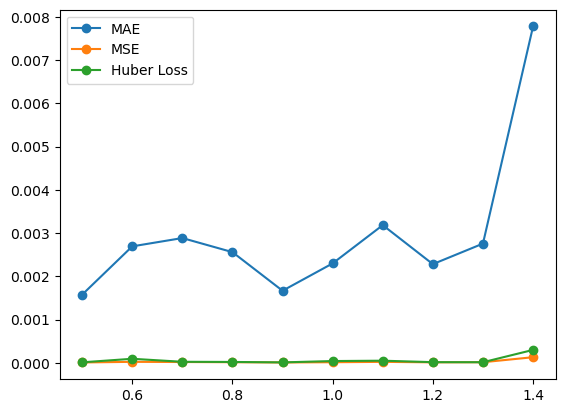

In [19]:

deltas = np.arange(0.5, 1.5, 0.1)
plt.plot(deltas, arr_val_mae, marker='o', linestyle='-', color='C0', label='MAE')
plt.plot(deltas, arr_val_mse, marker='o', linestyle='-', color='C1', label='MSE')
plt.plot(deltas, arr_val_loss, marker='o', linestyle='-', color='C2', label='Huber Loss')
plt.legend()

print(f"Best delta: {best_delta}")
print(f"Best validation MAE: {best_val_mae}")
print(f"Best validation MSE: {best_val_mse}")

In [20]:
# evaluate base model 
base_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation='relu'),
        Dense(1)
    ])

base_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta))

# initialise History object to save training history
history = History()

history = base_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

# create folder for models
if not os.path.exists("models"):
    os.makedirs("models")

# save model in models
base_model.save("models/base_dnn_model_raw_pd.h5")

# save model history in models
with open('models/base_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
base_train_hl = history.history["loss"][-1]
base_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {base_train_hl}")
print(f"Validation Huber Loss: {base_val_hl}")

Epoch 1/7
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0218 - val_loss: 8.3077e-05
Epoch 2/7
3125/3125 [==============================] - 2s 709us/step - loss: 8.3299e-04 - val_loss: 5.9028e-04
Epoch 3/7
3125/3125 [==============================] - 2s 761us/step - loss: 5.2939e-04 - val_loss: 8.0108e-05
Epoch 4/7
3125/3125 [==============================] - 2s 651us/step - loss: 3.7959e-04 - val_loss: 2.3829e-04
Epoch 5/7
3125/3125 [==============================] - 2s 735us/step - loss: 3.5731e-04 - val_loss: 1.5551e-04
Epoch 6/7
3125/3125 [==============================] - 3s 826us/step - loss: 1.6386e-04 - val_loss: 5.8048e-05
Epoch 7/7
3125/3125 [==============================] - 2s 636us/step - loss: 1.9930e-04 - val_loss: 3.5250e-05
Training Huber Loss: 0.00019930351118091494
Validation Huber Loss: 3.5249653592472896e-05


## Regularised Base Model

In [21]:
reg_model = Sequential([
        Dense(64, activation='relu', input_shape=(Xtrain.shape[1],), kernel_regularizer='l2'), 
        Dense(32, activation='relu', kernel_regularizer='l2'),
        Dense(1)
    ])

reg_model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=best_delta))

# initialise History object to save training history
history = History()

history = reg_model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=32, validation_data=(Xval, yval, wval), callbacks=[history])

Epoch 1/7
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0786 - val_loss: 0.0207
Epoch 2/7
3125/3125 [==============================] - 2s 679us/step - loss: 0.0166 - val_loss: 0.0153
Epoch 3/7
3125/3125 [==============================] - 2s 643us/step - loss: 0.0113 - val_loss: 0.0091
Epoch 4/7
3125/3125 [==============================] - 2s 630us/step - loss: 0.0083 - val_loss: 0.0068
Epoch 5/7
3125/3125 [==============================] - 2s 561us/step - loss: 0.0074 - val_loss: 0.0059
Epoch 6/7
3125/3125 [==============================] - 2s 603us/step - loss: 0.0060 - val_loss: 0.0053
Epoch 7/7
3125/3125 [==============================] - 2s 662us/step - loss: 0.0059 - val_loss: 0.0058


In [22]:
# create folder for models
if not os.path.exists("models"):
    os.makedirs("models")

# save model in models
base_model.save("models/reg_dnn_model_raw_pd.h5")

# save model history in models
with open('models/reg_dnn_model_raw_pd_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# print results
reg_train_hl = history.history["loss"][-1]
reg_val_hl = history.history["val_loss"][-1]
print(f"Training Huber Loss: {reg_train_hl}")
print(f"Validation Huber Loss: {reg_val_hl}")

Training Huber Loss: 0.005858905613422394
Validation Huber Loss: 0.005812895484268665


## Best Model

In [31]:
# define base model function for KerasRegressor
def create_model(activation='relu', optimizer='adam', learning_rate=0.001, kernel_regularizer=None, batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    # compile model
    optimizer = Adam(learning_rate=learning_rate) if optimizer == 'adam' else optimizer

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta))

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'activation': ['relu', 'tanh'],
    'optimizer': ['sgd', 'adam'],
    'learning_rate': [0.001, 0.01, 0.1],
    'kernel_regularizer': ['l1', 'l2', 'l1_l2'],
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform random search hyperparameter tuning
random_search = RandomizedSearchCV(estimator=keras_reg, param_distributions=param_dist, n_iter=10, cv=3, verbose=1, random_state=42, error_score='raise')

random_search.fit(Xtrain, ytrain, sample_weight=wtrain, validation_data=(Xval, yval, wval))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/7
3125/3125 [==============================] - 5s 1ms/step - loss: 1.7143 - val_loss: 1.8863
Epoch 2/7
3125/3125 [==============================] - 2s 790us/step - loss: 1.5183 - val_loss: 1.6517
Epoch 3/7
3125/3125 [==============================] - 3s 898us/step - loss: 1.4309 - val_loss: 1.4783
Epoch 4/7
3125/3125 [==============================] - 2s 632us/step - loss: 1.4370 - val_loss: 1.9195
Epoch 5/7
3125/3125 [==============================] - 3s 811us/step - loss: 1.3869 - val_loss: 0.8440
Epoch 6/7
3125/3125 [==============================] - 3s 825us/step - loss: 1.3782 - val_loss: 1.1524
Epoch 7/7
3125/3125 [==============================] - 3s 1ms/step - loss: 1.3578 - val_loss: 1.0989
Epoch 1/7
3125/3125 [==============================] - 5s 2ms/step - loss: 1.7067 - val_loss: 1.3446
Epoch 2/7
3125/3125 [==============================] - 3s 1ms/step - loss: 1.5713 - val_loss: 1.0589
Epoch 3/7
3125/3125 

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000026FDF8C2488>,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'batch_size': [16, 32, 64],
                                        'kernel_regularizer': ['l1', 'l2',
                                                               'l1_l2'],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'optimizer': ['sgd', 'adam']},
                   random_state=42, verbose=1)

In [32]:
random_search_df = pd.DataFrame(random_search.cv_results_)

display(random_search_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_learning_rate,param_kernel_regularizer,param_batch_size,param_activation,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,99.165775,0.680701,1.198195,0.200808,adam,0.1,l1,32,tanh,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-2.110169,-0.881396,-1.023361,-1.338309,0.548856,10
1,171.349581,1.135520,2.230540,0.057545,sgd,0.1,l2,16,relu,"{'optimizer': 'sgd', 'learning_rate': 0.1, 'ke...",-0.001118,-0.001144,-0.001144,-0.001136,0.000012,2
2,164.943705,6.912047,2.072949,0.106838,sgd,0.1,l1,16,relu,"{'optimizer': 'sgd', 'learning_rate': 0.1, 'ke...",-0.005374,-0.005411,-0.005925,-0.005570,0.000252,4
3,93.426578,2.064374,1.046472,0.003402,adam,0.1,l2,32,tanh,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-0.196950,-0.347173,-0.228355,-0.257493,0.064697,8
4,154.143682,3.506242,1.817034,0.276978,sgd,0.01,l2,16,tanh,"{'optimizer': 'sgd', 'learning_rate': 0.01, 'k...",-0.001751,-0.001638,-0.001923,-0.001771,0.000118,3
5,170.728736,1.303218,2.107222,0.100401,adam,0.001,l1_l2,16,tanh,"{'optimizer': 'adam', 'learning_rate': 0.001, ...",-0.016690,-0.018019,-0.020801,-0.018503,0.001713,6
6,88.781394,1.881336,1.023760,0.050558,sgd,0.001,l1_l2,32,relu,"{'optimizer': 'sgd', 'learning_rate': 0.001, '...",-0.006623,-0.007640,-0.006262,-0.006841,0.000584,5
7,37.329256,1.243411,0.565932,0.001435,adam,0.01,l2,64,relu,"{'optimizer': 'adam', 'learning_rate': 0.01, '...",-0.000898,-0.000602,-0.000643,-0.000714,0.000131,1
8,37.935507,1.588747,0.574437,0.006257,adam,0.1,l1,64,tanh,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-0.461995,-0.695902,-1.181719,-0.779872,0.299765,9
9,168.788510,2.959967,2.021222,0.006772,adam,0.1,l2,16,relu,"{'optimizer': 'adam', 'learning_rate': 0.1, 'k...",-0.008023,-0.091565,-0.009628,-0.036405,0.039009,7


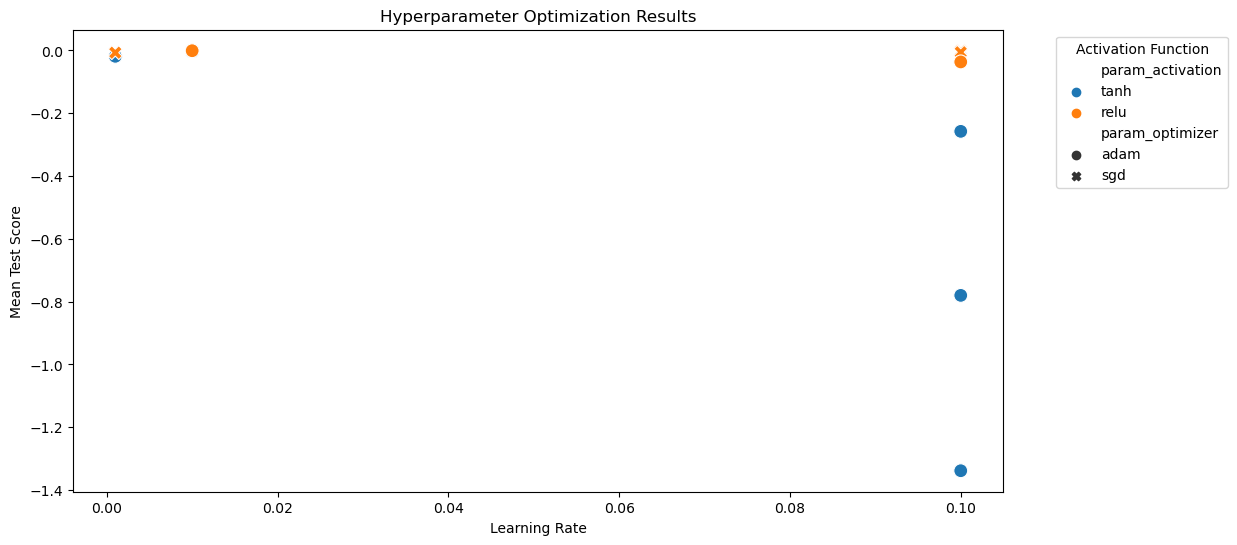

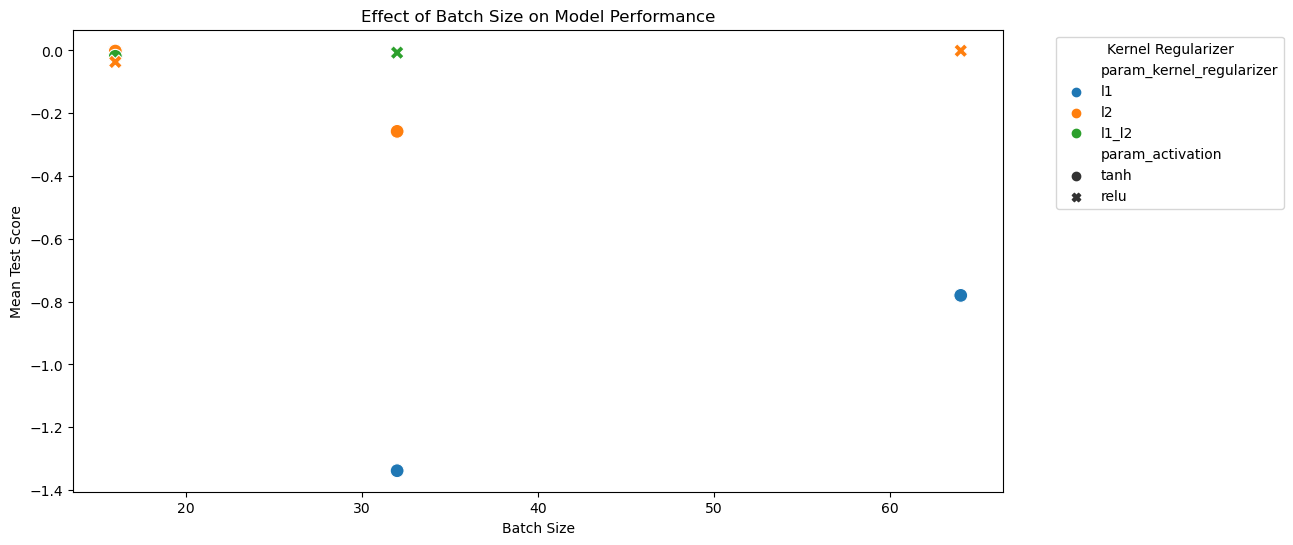

In [39]:
# Plot the results
plt.figure(figsize=(12, 6))

# Example of plotting one parameter against mean test score
sns.scatterplot(data=random_search_df, x='param_learning_rate', y='mean_test_score', hue='param_activation', style='param_optimizer', s=100)

plt.title('Hyperparameter Optimization Results')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Test Score')
plt.legend(title='Activation Function', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Another example: Visualizing the effect of batch size
plt.figure(figsize=(12, 6))
sns.scatterplot(data=random_search_df, x='param_batch_size', y='mean_test_score', hue='param_kernel_regularizer', style='param_activation', s=100)

plt.title('Effect of Batch Size on Model Performance')
plt.xlabel('Batch Size')
plt.ylabel('Mean Test Score')
plt.legend(title='Kernel Regularizer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [49]:
# grid search 

# define base model function for KerasRegressor
def create_model(activation='relu', optimizer='adam', kernel_regularizer='l2', batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta))

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01), Adam(learning_rate=0.1)],
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform grid search hyperparameter tuning
grid_search = GridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')

grid_search.fit(Xtrain, ytrain, sample_weight=wtrain)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Epoch 1/7
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0338 - val_loss: 0.0036
Epoch 2/7
6250/6250 [==============================] - 6s 908us/step - loss: 0.0053 - val_loss: 0.0028
Epoch 3/7
6250/6250 [==============================] - 8s 1ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/7
6250/6250 [==============================] - 6s 916us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 5/7
6250/6250 [==============================] - 6s 991us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 6/7
6250/6250 [==============================] - 5s 753us/step - loss: 0.0034 - val_loss: 0.0016
Epoch 7/7
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0035 - val_loss: 0.0015
[CV] END batch_size=16, optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000026FE9E3D708>; total time= 1.7min
Epoch 1/7
6250/6250 [==============================] - 6s 900us/step - loss: 0.0394 - val_lo

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000026FE9E3D148>, as the constructor either does not set or modifies parameter optimizer

In [50]:
# grid search 

# define base model function for KerasRegressor
def create_model(activation='relu', optimizer='sgd', kernel_regularizer='l2', batch_size=32):
    model = Sequential([
        Dense(64, activation=activation, input_shape=(Xtrain.shape[1],)), 
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer),
        Dense(1)
    ])

    model.compile(optimizer=optimizer, loss=Huber(delta=best_delta))

    model.fit(Xtrain, ytrain, sample_weight=wtrain, epochs=early_stop.stopped_epoch, batch_size=batch_size, validation_data=(Xval, yval, wval))

    return model

# define hyperparameter search space
param_dist = {
    'batch_size': [16, 32, 64]
}

# create a KerasRegressor wrapper for use in RandomizedSearchCV
keras_reg = KerasRegressor(build_fn=create_model, epochs=20, verbose=0)

# perform grid search hyperparameter tuning
grid_search = GridSearchCV(estimator=keras_reg, param_grid=param_dist, cv=5, verbose=2, error_score='raise')

grid_search.fit(Xtrain, ytrain, sample_weight=wtrain)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/7
6250/6250 [==============================] - 9s 1ms/step - loss: 0.1679 - val_loss: 0.0400
Epoch 2/7
6250/6250 [==============================] - 6s 978us/step - loss: 0.0172 - val_loss: 0.0065
Epoch 3/7
6250/6250 [==============================] - 6s 899us/step - loss: 0.0042 - val_loss: 0.0030
Epoch 4/7
6250/6250 [==============================] - 7s 1ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 5/7
6250/6250 [==============================] - 5s 726us/step - loss: 0.0028 - val_loss: 0.0020
Epoch 6/7
6250/6250 [==============================] - 5s 754us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/7
6250/6250 [==============================] - 6s 968us/step - loss: 0.0037 - val_loss: 0.0018
[CV] END ......................................batch_size=16; total time= 1.7min
Epoch 1/7
6250/6250 [==============================] - 5s 807us/step - loss: 0.1751 - val_loss: 0.0413
Epoch 2/7
6250/6250 [==================

GridSearchCV(cv=5, error_score='raise',
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000026FE9E3D3C8>,
             param_grid={'batch_size': [16, 32, 64]}, verbose=2)

In [44]:
grid_search_df = pd.DataFrame(grid_search.cv_results_)

display(grid_search_df)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [28]:
# get the best model and its hyperparameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'optimizer': 'adam', 'learning_rate': 0.01, 'kernel_regularizer': 'l2', 'batch_size': 64, 'activation': 'relu'}


In [65]:
# save the best model
best_model = create_model(activation='tanh', optimizer='adam', learning_rate=0.001, batch_size=16, kernel_regularizer='l2')
best_model.fit(Xtrain, ytrain, epochs=20, batch_size=16, validation_data=(Xval,yval), verbose=1)
base_model.save("best_dnn_model_raw.h5")

Epoch 1/20
5860/5860 [==============================] - 5s 919us/step - loss: 0.0327 - val_loss: 0.0031
Epoch 2/20
5860/5860 [==============================] - 5s 827us/step - loss: 0.0015 - val_loss: 7.7626e-04
Epoch 3/20
5860/5860 [==============================] - 5s 825us/step - loss: 0.0014 - val_loss: 7.1127e-04
Epoch 4/20
5860/5860 [==============================] - 5s 801us/step - loss: 0.0012 - val_loss: 7.2515e-04
Epoch 5/20
5860/5860 [==============================] - 5s 796us/step - loss: 0.0011 - val_loss: 6.0863e-04
Epoch 6/20
5860/5860 [==============================] - 5s 808us/step - loss: 0.0011 - val_loss: 5.9080e-04
Epoch 7/20
5860/5860 [==============================] - 5s 782us/step - loss: 0.0012 - val_loss: 5.8227e-04
Epoch 8/20
5860/5860 [==============================] - 5s 799us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/20
5860/5860 [==============================] - 5s 778us/step - loss: 0.0010 - val_loss: 5.4847e-04
Epoch 10/20
5860/5860 [=============

Best Training MSE: 0.0009268095018342137
Best Validation MSE: 0.00043869437649846077


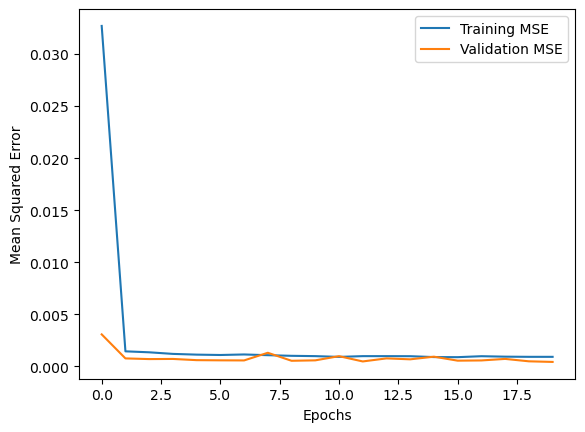

In [66]:
best_train_mse = best_model.history.history["loss"][-1]
best_val_mse = best_model.history.history["val_loss"][-1]
print(f"Best Training MSE: {best_train_mse}")
print(f"Best Validation MSE: {best_val_mse}")

plt.plot(best_model.history.history['loss'], label='Training MSE')
plt.plot(best_model.history.history['val_loss'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Processed best model: 'optimizer': 'adam', 'learning_rate': 0.001, 'kernel_regularizer': 'l2', 'batch_size': 16, 'activation': 'tanh'

Raw best model: 'optimizer': 'sgd', 'learning_rate': 0.1, 'kernel_regularizer': None, 'batch_size': 16, 'activation': 'relu'